In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import ConcatDataset
import torchvision
from torchvision import transforms

from dataloading.nvidia import NvidiaTrainDataset, NvidiaSpringTrainDataset, NvidiaValidationDataset
from network import PilotNet
from trainer import Trainer

import wandb

%load_ext autoreload
%autoreload 2

# Config

## Datasets

In [2]:
root_path = Path("/media/romet/data2/datasets/rally-estonia/dataset")
trainset = NvidiaTrainDataset(root_path)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True,
                                         num_workers=60, pin_memory=True, persistent_workers=True)
print(len(trainset.frames))

/media/romet/data2/datasets/rally-estonia/dataset/2021-05-20-12-36-10_e2e_sulaoja_20_30: 12025
/media/romet/data2/datasets/rally-estonia/dataset/2021-05-20-12-43-17_e2e_sulaoja_20_30: 6809
/media/romet/data2/datasets/rally-estonia/dataset/2021-05-20-12-51-29_e2e_sulaoja_20_30: 5393
/media/romet/data2/datasets/rally-estonia/dataset/2021-05-20-13-44-06_e2e_sulaoja_10_10: 3833
/media/romet/data2/datasets/rally-estonia/dataset/2021-05-20-13-51-21_e2e_sulaoja_10_10: 3798
/media/romet/data2/datasets/rally-estonia/dataset/2021-05-20-13-59-00_e2e_sulaoja_10_10: 687
/media/romet/data2/datasets/rally-estonia/dataset/2021-05-28-15-07-56_e2e_sulaoja_20_30: 15626
/media/romet/data2/datasets/rally-estonia/dataset/2021-05-28-15-17-19_e2e_sulaoja_20_30: 3218
/media/romet/data2/datasets/rally-estonia/dataset/2021-06-09-13-14-51_e2e_rec_ss2: 49918
/media/romet/data2/datasets/rally-estonia/dataset/2021-06-09-13-55-03_e2e_rec_ss2_backwards: 53743
/media/romet/data2/datasets/rally-estonia/dataset/2021-06-0

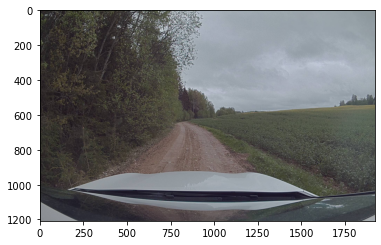

In [11]:
image_path = trainset.frames.iloc[0].image_path
image = torchvision.io.read_image(image_path)
plt.imshow(image.permute(1, 2, 0))

In [15]:
def crop(image):
    xmin = 300
    xmax = 1620

    ymin = 520
    ymax = 864

    scale = 0.2

    height = ymax - ymin
    width = xmax - xmin
    cropped_image = transforms.functional.resized_crop(image, ymin, xmin, height, width,
                                                     (int(scale*height), int(scale*width)))
    return cropped_image

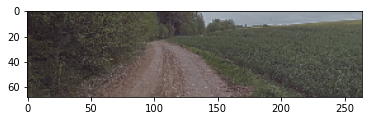

In [16]:
cropped_image = crop(image)
plt.imshow(cropped_image.permute(1, 2, 0))

In [41]:
import cv2

xmin = 300
xmax = 1620
ymin = 520
ymax = 864
scale = 0.2

height = ymax - ymin
width = xmax - xmin
scaled_width = int(scale * width)
scaled_height = int(scale * height)

def resize(img):
    return cv2.resize(img, dsize=(scaled_width, scaled_height), interpolation=cv2.INTER_LINEAR)

In [43]:
images = trainset.frames.image_path.to_numpy()
for image_path in tqdm(images):
    path = Path(image_path)
    image_name = path.name
    root_folder = path.parent.parent
    crop_folder = root_folder / "front_wide_cropped"
    crop_folder.mkdir(exist_ok=True)
    
    #image = torchvision.io.read_image(image_path)
    #cropped_image = crop(image)
    #torchvision.io.write_jpeg(cropped_image, str(crop_folder / image_name), quality=100)
    
    image = cv2.imread(image_path)
    cropped_image = resize(image)
    cv2.imwrite(str(crop_folder / image_name), cropped_image, [cv2.IMWRITE_JPEG_QUALITY, 100])


  0%|          | 0/1347049 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [4]:

validset = NvidiaValidationDataset(root_path)
validloader = torch.utils.data.DataLoader(validset, batch_size=64, shuffle=False,
                                         num_workers=32, pin_memory=True, persistent_workers=True)
print(len(validset.frames))

/media/romet/data2/datasets/rally-estonia/dataset/2021-05-28-15-19-48_e2e_sulaoja_20_30: 10708
/media/romet/data2/datasets/rally-estonia/dataset/2021-06-07-14-20-07_e2e_rec_ss6: 25836
/media/romet/data2/datasets/rally-estonia/dataset/2021-06-07-14-06-31_e2e_rec_ss6: 3003
/media/romet/data2/datasets/rally-estonia/dataset/2021-06-07-14-09-18_e2e_rec_ss6: 4551
/media/romet/data2/datasets/rally-estonia/dataset/2021-06-07-14-36-16_e2e_rec_ss6: 25368
/media/romet/data2/datasets/rally-estonia/dataset/2021-09-24-14-03-45_e2e_rec_ss11_backwards: 25172
/media/romet/data2/datasets/rally-estonia/dataset/2021-10-26-10-49-06_e2e_rec_ss20_elva: 33045
/media/romet/data2/datasets/rally-estonia/dataset/2021-10-26-11-08-59_e2e_rec_ss20_elva_back: 33281
/media/romet/data2/datasets/rally-estonia/dataset/2021-10-20-15-11-29_e2e_rec_vastse_ss13_17_back: 26763
/media/romet/data2/datasets/rally-estonia/dataset/2021-10-11-14-50-59_e2e_rec_vahi: 21211
/media/romet/data2/datasets/rally-estonia/dataset/2021-10-14-